In [8]:
# 라이브러리 임포트 및 기본 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'   # Windows
plt.rcParams['axes.unicode_minus'] = False      # 마이너스 기호 깨짐 방지
plt.rcParams['figure.dpi'] = 100                # 그래프 해상도

In [15]:
def load_weather_csv(file_path, encoding='cp949'):
    import os
    import pandas as pd

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"파일 없음: {file_path}")

    # 헤더 탐색
    start_row = None
    with open(file_path, encoding=encoding, errors='ignore') as f:
        for i, line in enumerate(f):
            if '지점번호' in line:
                start_row = i
                break

    if start_row is None:
        raise ValueError("헤더('지점번호')를 찾을 수 없음")

    df = pd.read_csv(
        file_path,
        encoding=encoding,
        skiprows=start_row,
        engine='python'
    )

    # 컬럼 정리
    df.columns = df.columns.str.strip()

    # 문자열 정리 (applymap 제거)
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].str.strip()

    # 🔥 날짜 자동 변환 (핵심 수정)
    df['일시'] = pd.to_datetime(
        df['일시'],
        errors='coerce'
    )

    # 날짜 없는 행 제거
    df = (
        df.dropna(subset=['일시'])
          .sort_values('일시')
          .reset_index(drop=True)
    )

    return df
weather_45 = load_weather_csv('incheon_weather_data_4~5.csv')
weather_67 = load_weather_csv('incheon_weather_data_6~7.csv')
print(weather_45.head())
print(weather_67.head())




   지점번호 지점명         일시  강수량(mm)  일최다강수량(mm)    일최다강수량일자  1시간최다강수량(mm)  \
0   112  인천 2015-04-01     53.7        17.1  2015-04-19           7.9   
1   112  인천 2015-05-01     30.1        20.3  2015-05-11           6.7   
2   112  인천 2016-04-01     80.8        30.5  2016-04-16           9.0   
3   112  인천 2016-05-01    148.5        40.8  2016-05-24           9.3   
4   112  인천 2017-04-01     57.0        41.3  2017-04-05           9.0   

   1시간최다강수량일자  Unnamed: 8  
0  2015-04-02         NaN  
1  2015-05-11         NaN  
2  2016-04-16         NaN  
3  2016-05-03         NaN  
4  2017-04-05         NaN  
   지점번호 지점명         일시  강수량(mm)  일최다강수량(mm)    일최다강수량일자  1시간최다강수량(mm)  \
0   112  인천 2020-06-01    100.2        32.5  2020-06-30          12.3   
1   112  인천 2020-07-01    243.5       101.8  2020-07-23          18.5   
2   112  인천 2021-06-01     45.4        16.1  2021-06-03           6.1   
3   112  인천 2021-07-01     84.2        52.7  2021-07-03          12.9   
4   112  인천 2022-06-01    28

In [17]:
def load_solar_csv(file_path):
    import pandas as pd

    start_row = None
    with open(file_path, encoding='cp949') as f:
        for i, line in enumerate(f):
            if '지점번호' in line:
                start_row = i
                break

    df = pd.read_csv(
        file_path,
        encoding='cp949',
        skiprows=start_row,
        engine='python'
    )

    # 컬럼명 정리
    df.columns = df.columns.str.strip()

    # 🔥 탭 + 공백 제거 (핵심)
    df = df.applymap(
        lambda x: x.replace('\t', '').strip() if isinstance(x, str) else x
    )

    # 날짜 변환
    df['일시'] = pd.to_datetime(
        df['일시'],
        format='%b-%y',
        errors='coerce'
    )

    df = (
        df
        .dropna(subset=['일시'])
        .sort_values('일시')
        .reset_index(drop=True)
    )

    return df

solar_67 = load_solar_csv('incheon_solar_data_6~7.csv')
solar_45 = load_solar_csv('incheon_solar_data_4~5.csv')

print("\n장마철 일사량:")
print(solar_67.head())

print("\n비장마철 일사량:")
print(solar_45.head())



장마철 일사량:
  지점번호 지점명         일시  일조합(hr)  일조율(%)  일사합(MJ/m2)
0  112  인천 2020-06-01    238.2   53.95      598.68
1  112  인천 2020-07-01    173.5   38.72      480.60
2  112  인천 2021-06-01    232.7   52.71      580.67
3  112  인천 2021-07-01    270.1   60.25      623.39
4  112  인천 2022-06-01    145.9   33.05      475.95

비장마철 일사량:
  지점번호 지점명         일시  일조합(hr)  일조율(%)  일사합(MJ/m2)
0  112  인천 2020-04-01    316.7   80.06      647.34
1  112  인천 2020-05-01    212.8   48.31      555.06
2  112  인천 2021-04-01    233.8   59.14      547.80
3  112  인천 2021-05-01    240.1   54.56      571.02
4  112  인천 2022-04-01    248.6   62.94      616.66


C:\Users\jjwan\AppData\Local\Temp\ipykernel_10412\2034159738.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(
C:\Users\jjwan\AppData\Local\Temp\ipykernel_10412\2034159738.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [19]:
# MJ/m² → kWh/m² 변환
# 일사량 변환: MJ/m² × 0.2778 = kWh/m²
solar_67['일사량(kWh/m²)'] = solar_67['일사합(MJ/m2)'] * 0.2778
solar_45['일사량(kWh/m²)'] = solar_45['일사합(MJ/m2)'] * 0.2778

# 발전량 계산 (패널 20m², 효율 18%, 손실 20%)
solar_67['발전량(kWh)'] = solar_67['일사량(kWh/m²)'] * 20 * 0.18 * 0.8
solar_45['발전량(kWh)'] = solar_45['일사량(kWh/m²)'] * 20 * 0.18 * 0.8

# 전체 컬럼 확인
print("장마철:")
print(solar_67)

print("\n비장마철:")
print(solar_45)

장마철:
   지점번호 지점명         일시  일조합(hr)  일조율(%)  일사합(MJ/m2)  일사량(kWh/m²)    발전량(kWh)
0   112  인천 2020-06-01    238.2   53.95      598.68   166.313304  478.982316
1   112  인천 2020-07-01    173.5   38.72      480.60   133.510680  384.510758
2   112  인천 2021-06-01    232.7   52.71      580.67   161.310126  464.573163
3   112  인천 2021-07-01    270.1   60.25      623.39   173.177742  498.751897
4   112  인천 2022-06-01    145.9   33.05      475.95   132.218910  380.790461
5   112  인천 2022-07-01    198.5   44.26      610.83   169.688574  488.703093
6   112  인천 2023-06-01    229.9   52.07      626.15   173.944470  500.960074
7   112  인천 2023-07-01    182.6   40.70      527.89   146.647842  422.345785
8   112  인천 2024-06-01    305.9   69.29      741.25   205.919250  593.047440
9   112  인천 2024-07-01    125.3   27.96      455.02   126.404556  364.045121
10  112  인천 2025-06-01    209.5   47.46      603.25   167.582850  482.638608
11  112  인천 2025-07-01    217.9   48.61      616.28   171.202584  493.0

In [20]:
# 장마철
merged_67 = pd.merge(
    weather_67[['일시', '강수량(mm)']],
    solar_67[['일시', '일사량(kWh/m²)', '발전량(kWh)', '일조합(hr)']],
    on='일시'
)

# 비장마철
merged_45 = pd.merge(
    weather_45[['일시', '강수량(mm)']],
    solar_45[['일시', '일사량(kWh/m²)', '발전량(kWh)', '일조합(hr)']],
    on='일시' # 같은 날짜끼리 붙이기
)

# 발전량 비교

print("="*30)
print("발전량 분석")
print("="*30)

avg_power_67 = merged_67['발전량(kWh)'].mean()
avg_power_45 = merged_45['발전량(kWh)'].mean()
power_loss = avg_power_45 - avg_power_67
loss_percent = (power_loss / avg_power_45) * 100

print(f"\n비장마철 평균 발전량: {avg_power_45:.0f} kWh")
print(f"장마철 평균 발전량: {avg_power_67:.0f} kWh")
print(f"→ 장마철 감소: {power_loss:.0f} kWh ({loss_percent:.1f}% 감소)")


발전량 분석

비장마철 평균 발전량: 481 kWh
장마철 평균 발전량: 463 kWh
→ 장마철 감소: 18 kWh (3.8% 감소)


In [21]:
print("\n" + "="*30)
print("상관관계 분석")
print("="*30 + "\n")

# 장마철 상관관계
corr_67 = merged_67[['강수량(mm)', '발전량(kWh)']].corr().iloc[0, 1]
z_67 = np.polyfit(merged_67['강수량(mm)'], merged_67['발전량(kWh)'], 1)

# 비장마철 상관관계
corr_45 = merged_45[['강수량(mm)', '발전량(kWh)']].corr().iloc[0, 1]
z_45 = np.polyfit(merged_45['강수량(mm)'], merged_45['발전량(kWh)'], 1)

print(f"장마철 상관계수: {corr_67:.3f}")
print(f"  → 강수량 100mm ↑ → 발전량 {abs(z_67[0]*100):.0f}kWh ↓")
print(f"\n비장마철 상관계수: {corr_45:.3f}")
print(f"  → 강수량 100mm ↑ → 발전량 {abs(z_45[0]*100):.0f}kWh ↓")


상관관계 분석

장마철 상관계수: -0.679
  → 강수량 100mm ↑ → 발전량 41kWh ↓

비장마철 상관계수: -0.366
  → 강수량 100mm ↑ → 발전량 33kWh ↓


In [22]:
print("\n" + "="*30)
print("ESS 필요 용량 (일반 가정 기준)")
print("="*30 + "\n")

PANEL_AREA = 20  # m²
MONTHLY_NEED = 400 # 4인 가족 평균 한 달 동안 필요한 전기량 = 400kWh
worst = merged_67.loc[merged_67['발전량(kWh)'].idxmin()] # 장마철 중에서 발전량이 가장 적었던 달
shortage = max(0, MONTHLY_NEED - worst['발전량(kWh)']) # 필요한 전기 - 만든 전기 = 부족한 전기
                                                       # max(0,...) -> max(0, -100) = 0 음수 대신 0출력, 부족하지 않으면 0으로
recommended = shortage * 1.2    # 부족량에 20% 여유분 추가
commercial = int(np.ceil(recommended / 10)) * 10 # 상용 제품 단위로 올림 (실제 제품: 10kWh, 20kWh, 30kWh...단위로 판매)

print(f"\n패널 면적: {PANEL_AREA}m² (약 15개)")
print(f"월 필요량: {MONTHLY_NEED} kWh (4인 가족)")
print(f"평균 발전량: {merged_67['발전량(kWh)'].mean():.0f} kWh")
print(f"최악 발전량: {worst['발전량(kWh)']:.0f} kWh ({worst['일시'].strftime('%Y년 %m월')})")
print(f"부족량: {shortage:.0f} kWh")
print(f"권장 ESS: {commercial} kWh")
print(f"예상 비용: 약 {commercial * 500000:,}원") # 용량 * 단가 = 총 비용
                                                 # 50만원은 ESS 배터리 시장 평균 단가


ESS 필요 용량 (일반 가정 기준)


패널 면적: 20m² (약 15개)
월 필요량: 400 kWh (4인 가족)
평균 발전량: 463 kWh
최악 발전량: 364 kWh (2024년 07월)
부족량: 36 kWh
권장 ESS: 50 kWh
예상 비용: 약 25,000,000원


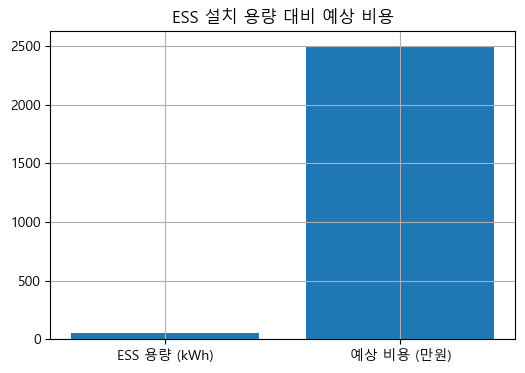

In [23]:
plt.figure(figsize=(6, 4))

plt.bar(
    ['ESS 용량 (kWh)', '예상 비용 (만원)'],
    [commercial, commercial * 50]
)

plt.title('ESS 설치 용량 대비 예상 비용')
plt.grid(True)

plt.show()
